<a href="https://colab.research.google.com/github/Hsieh121/generative_ai/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安裝gradio

In [ ]:
!pip install gradio

# 引用需要的套件

In [ ]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路方面
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 互動設計用
from ipywidgets import interact_manual

# 神速打造 web app 的 Gradio
import gradio as gr

# 載入資料並處理資料

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #從minist讀入資料

#Flatten影像，把28×28的影像展平成784維的向量，並把資料縮到0~1
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255

#0~9有10種可能，把輸出變成向量
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 建立模型並訓練
過程中有另外嘗試epoch=20,30,35，並搭配其他優化器，但結果提升有限，卻花費更多訓練時間，因此我決定留下此版本。此外我有使用dropout避免訓練過程發生overfitting。

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()

#各層神經元數量
N1 = 160
N2 = 320
N3 = 640
N4 = 1280


model.add(Dense(N1, input_dim=784, activation='relu'))  #輸入層
model.add(Dropout(0.2))
model.add(Dense(N2, activation='relu'))                 #第二層
model.add(Dropout(0.2))
model.add(Dense(N3, activation='relu'))                 #第三層
model.add(Dropout(0.2))
model.add(Dense(N4, activation='relu'))                 #第四層
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))              #輸出層

#選擇adam作為優化器，損失函數選擇分類問題較適合的categorical_crossentropy，並加入['accuracy']以便檢視精確度
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary() #檢視模型

model.fit(x_train, y_train, batch_size=80, epochs=15) #訓練

# 進行預測並檢視結果

In [ ]:
predict = np.argmax(model.predict(x_test), axis=-1)  #把機率最大的輸出取出最為答案

def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys') #印出圖
    print('神經網路判斷為:', predict[測試編號]) #印出預測結果

#可查詢各筆資料預測結果
interact_manual(test, 測試編號=(0, 9999));

#檢視訓練結果
score = model.evaluate(x_test, y_test)
print('loss:', score[0])
print('正確率', score[1])

In [ ]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [ ]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

# GRADIO預測結果

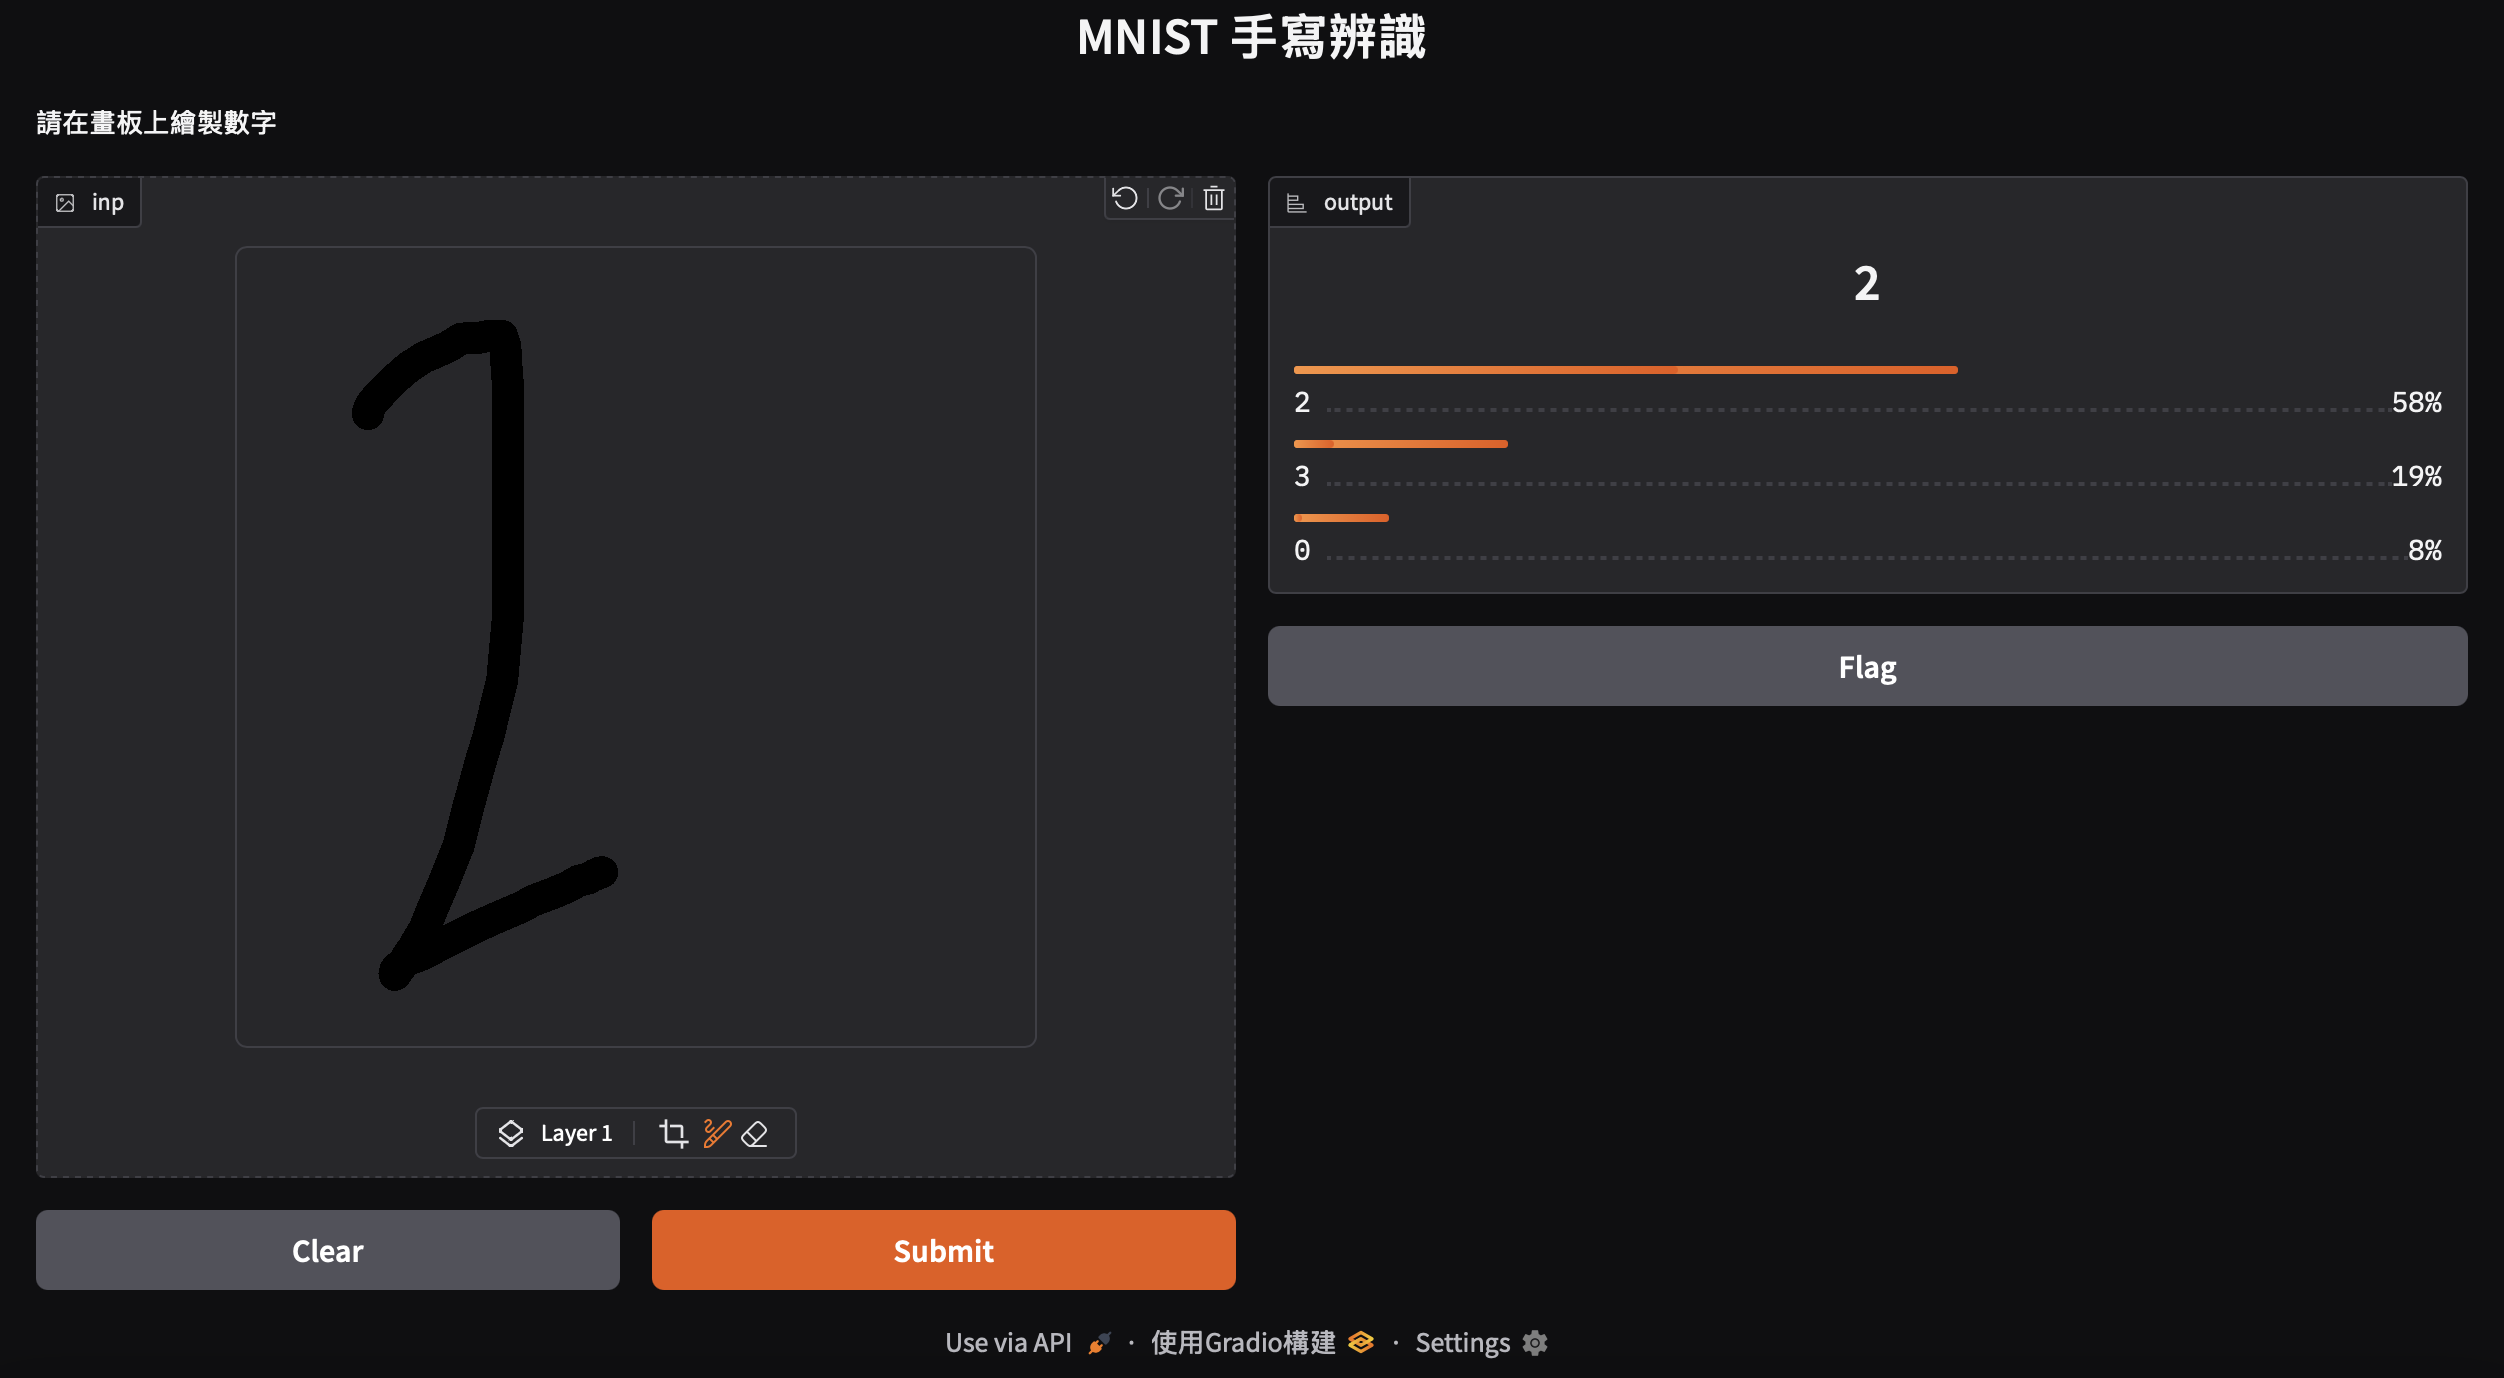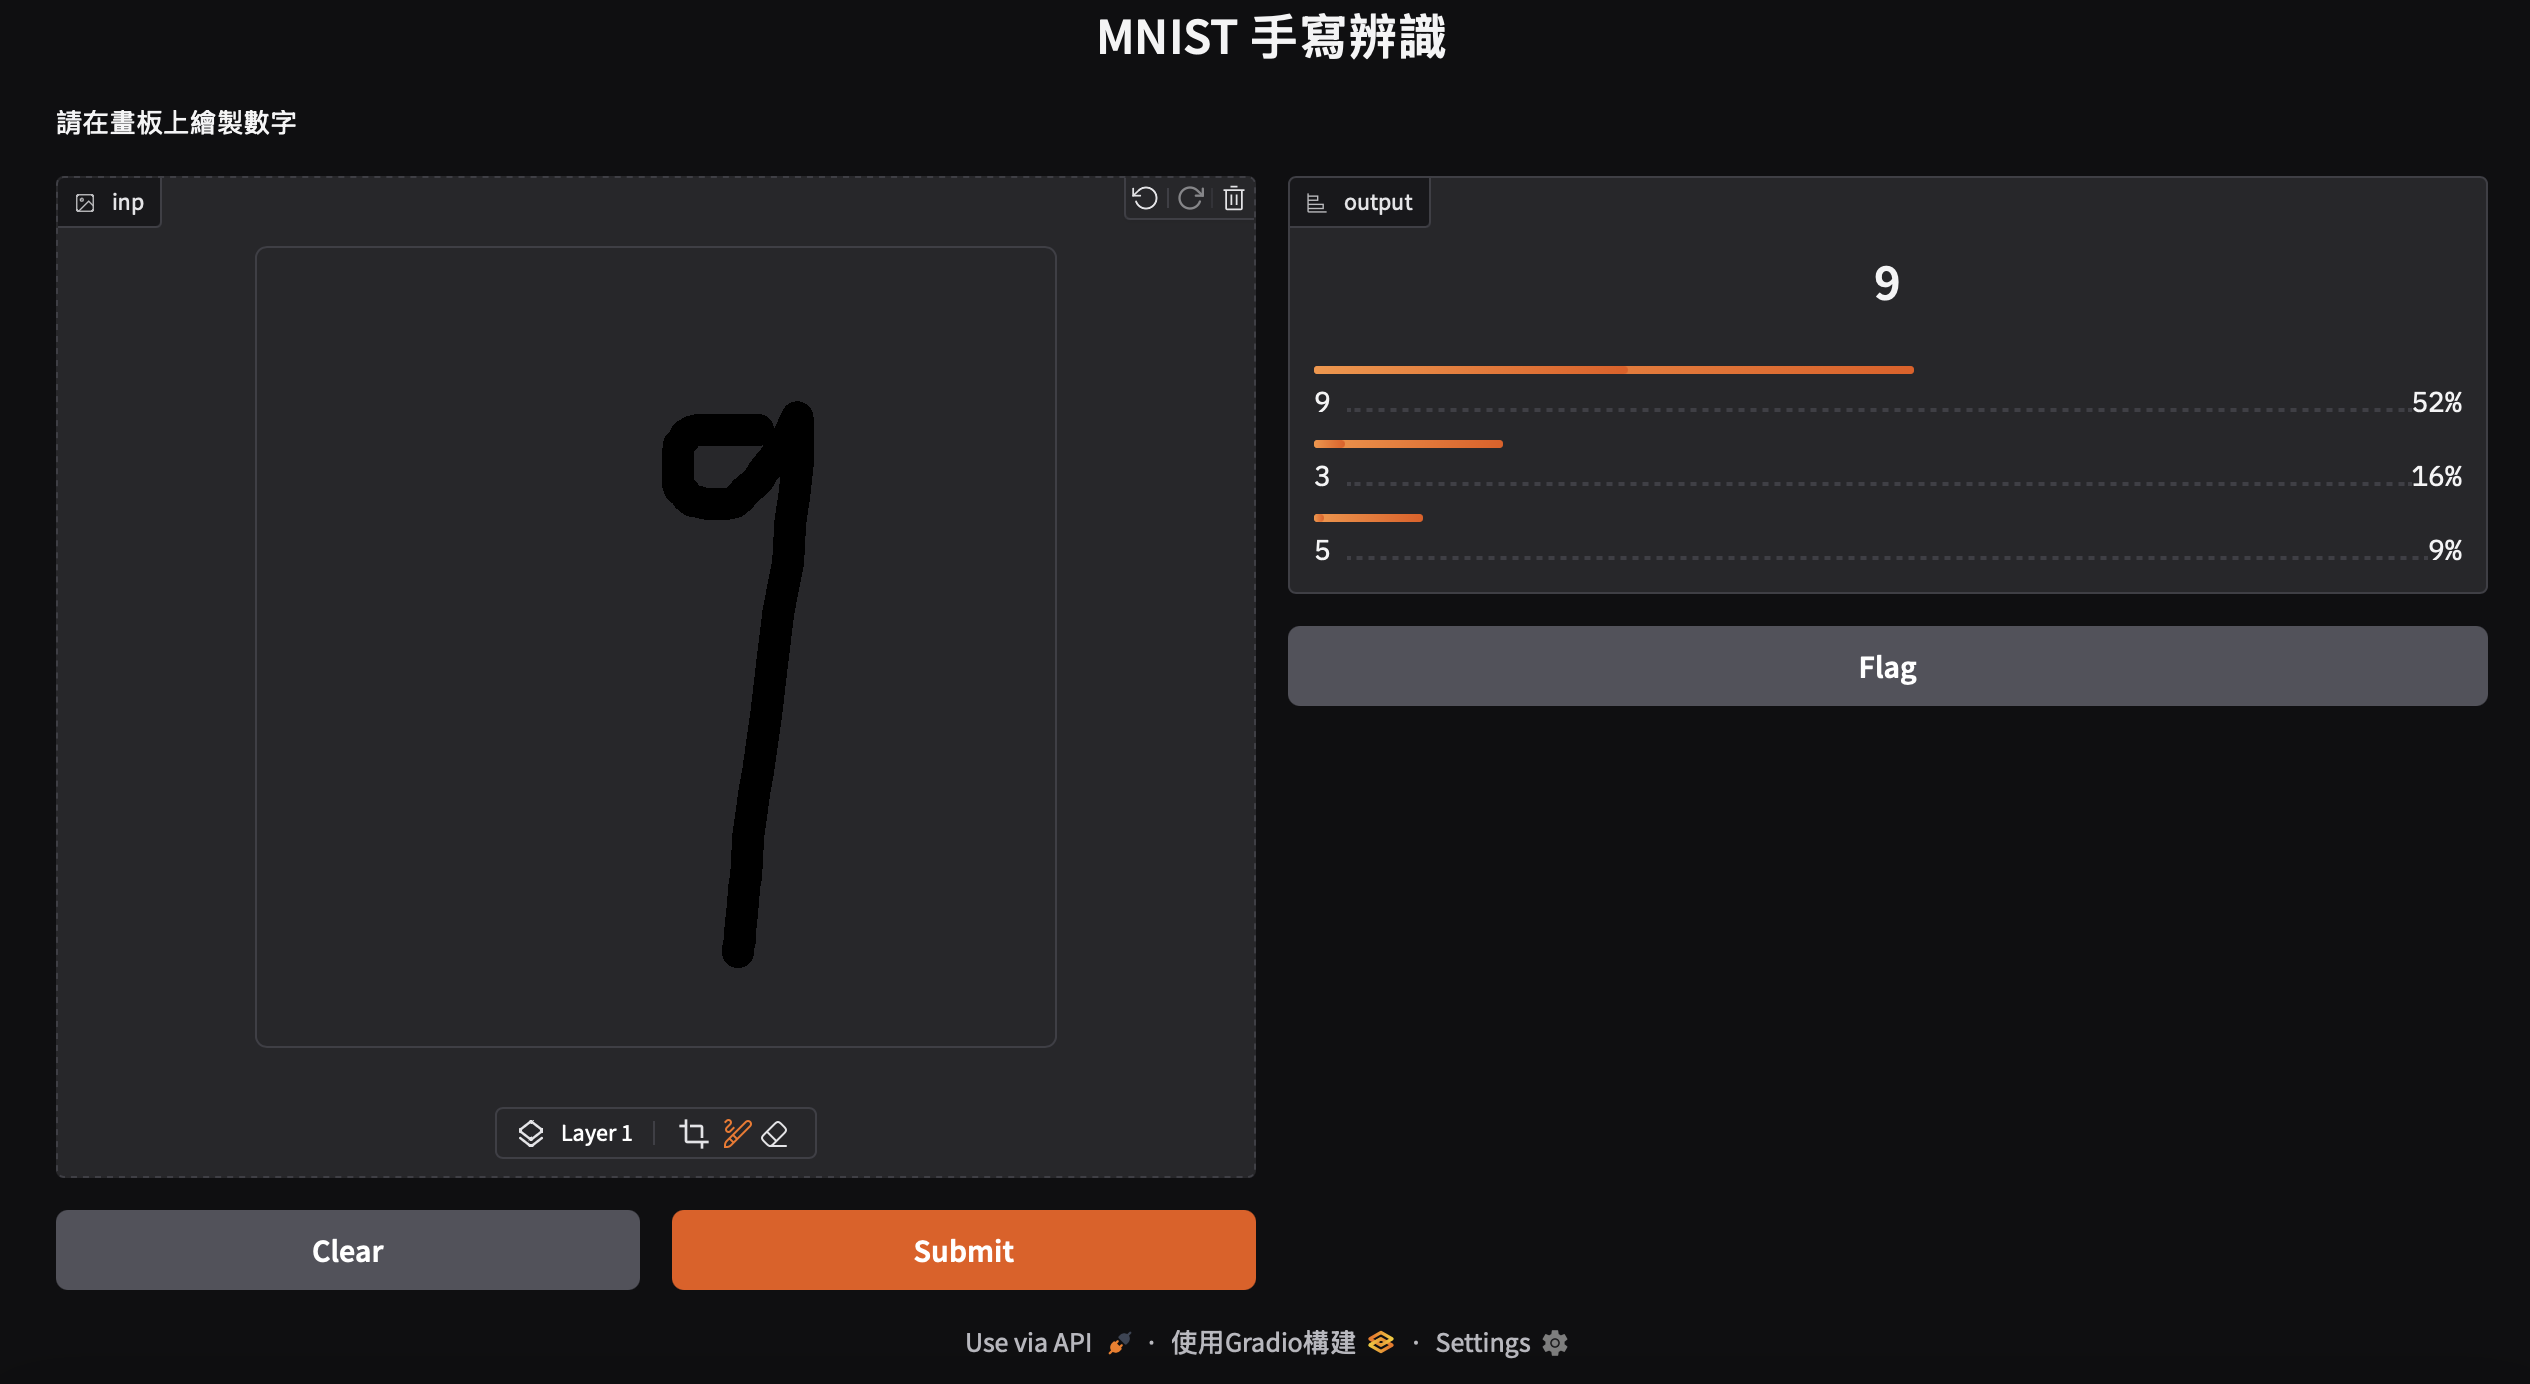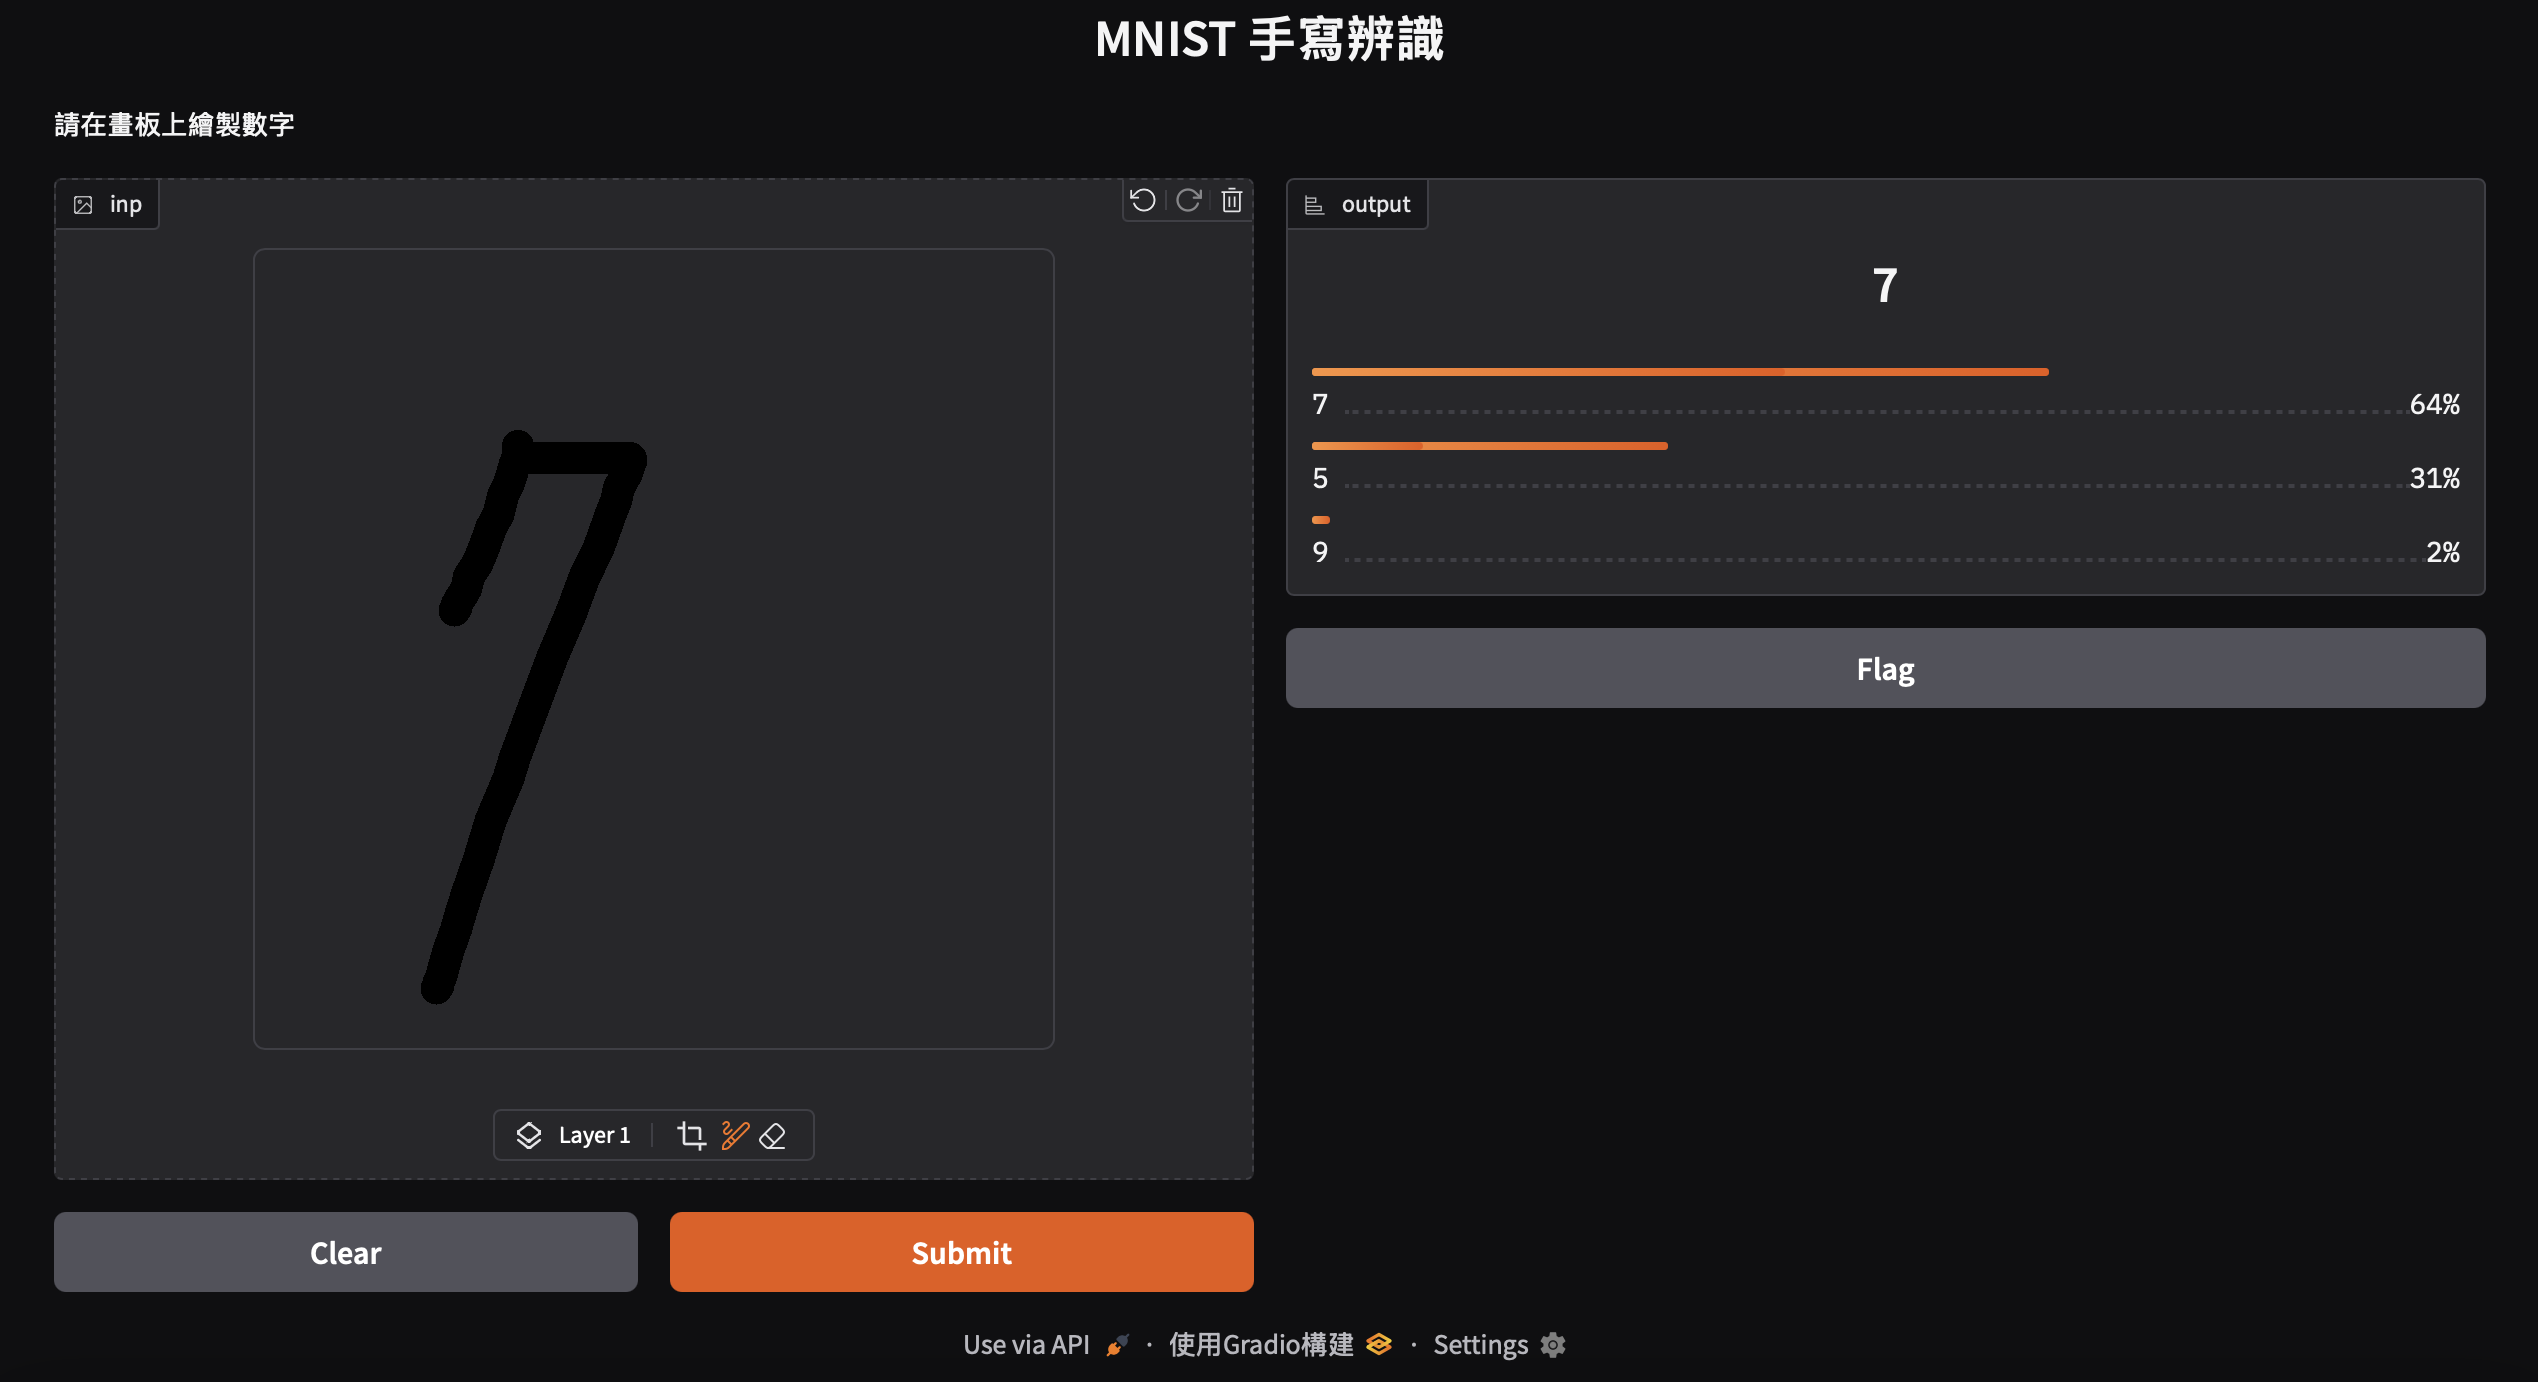